In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score
import joblib
import pickle
import warnings
warnings.filterwarnings('ignore')


In [2]:
data=pd.read_csv(r"C:\Users\Suresh\Desktop\Credit Card Fraud Dataset\fraudTrain.csv")
data2=data.copy()

In [3]:
testing=data[:10000]

In [4]:
testing.dtypes

trans_date_trans_time     object
cc_num                   float64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

## Class imbalance 

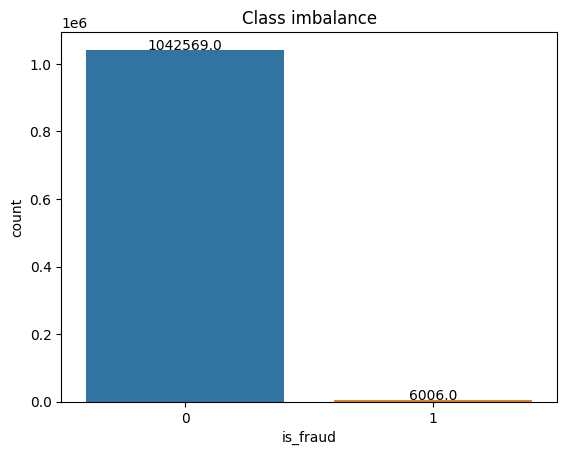

In [5]:
ax = sns.countplot(x='is_fraud', data=data)
plt.title('Class imbalance')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 0.1,height,ha="center")
plt.show()

## Analysis of Fraud Rate and Transaction Amount

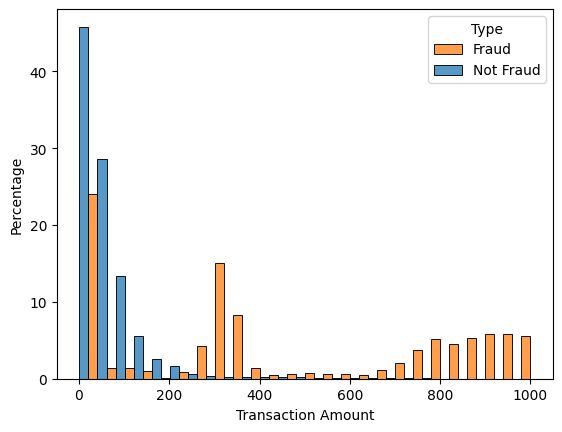

In [6]:
ax=sns.histplot(x='amt',data=data[data.amt<=1000],hue='is_fraud',stat='percent',multiple='dodge',common_norm=False,bins=25)
ax.set_ylabel('Percentage')
ax.set_xlabel('Transaction Amount')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

## Analysis of Fraud Rate and Gender

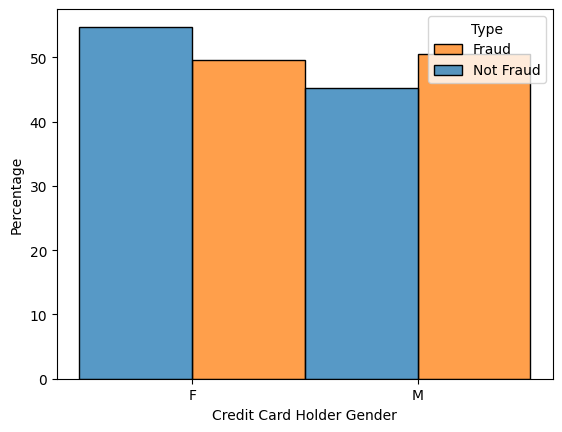

In [7]:
ax=sns.histplot(x='gender',data=data, hue='is_fraud',stat='percent',multiple='dodge',common_norm=False)
ax.set_ylabel('Percentage')
ax.set_xlabel('Credit Card Holder Gender')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

## Age Distribution in Fraudulent vs Non-Fraudulent Transactions

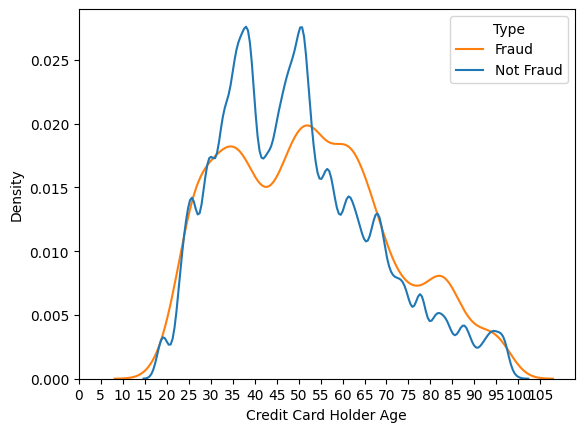

In [8]:
data['age']=dt.date.today().year-pd.to_datetime(data['dob']).dt.year
ax=sns.kdeplot(x='age',data=data, hue='is_fraud', common_norm=False)
ax.set_xlabel('Credit Card Holder Age')
ax.set_ylabel('Density')
plt.xticks(np.arange(0,110,5))
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

## Fraud Frequency for Hour of Day

Text(0.5, 0, 'Hour of Day')

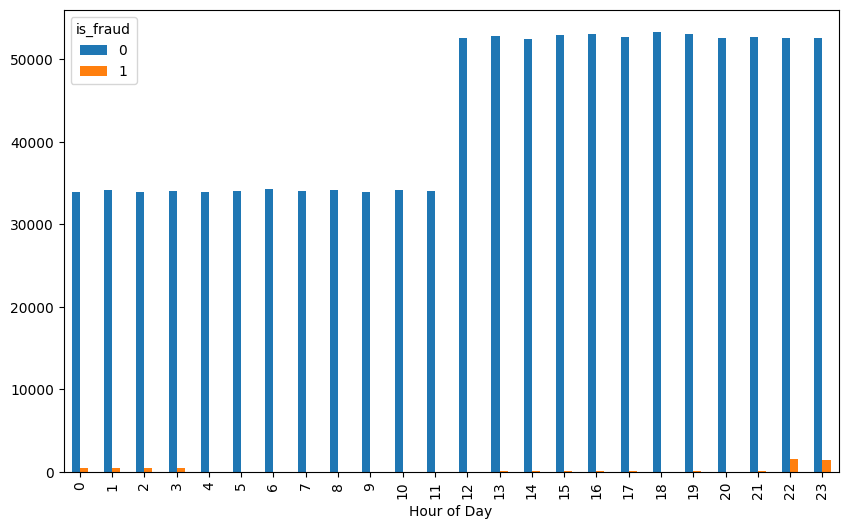

In [9]:
data["trans_date_trans_time"] = pd.to_datetime(data["trans_date_trans_time"])
data['dob']=pd.to_datetime(data['dob'])
data.rename(columns={"trans_date_trans_time":"trans_time"}, inplace=True)
data["month"] = data["trans_time"].dt.month
data["hour"] = data["trans_time"].dt.hour
data["year"] = data["trans_time"].dt.year
pd.crosstab(data['hour'], data['is_fraud']).plot(kind='bar', figsize=(10, 6)) 
plt.xlabel('Hour of Day') 

## State-wise fraud distribution

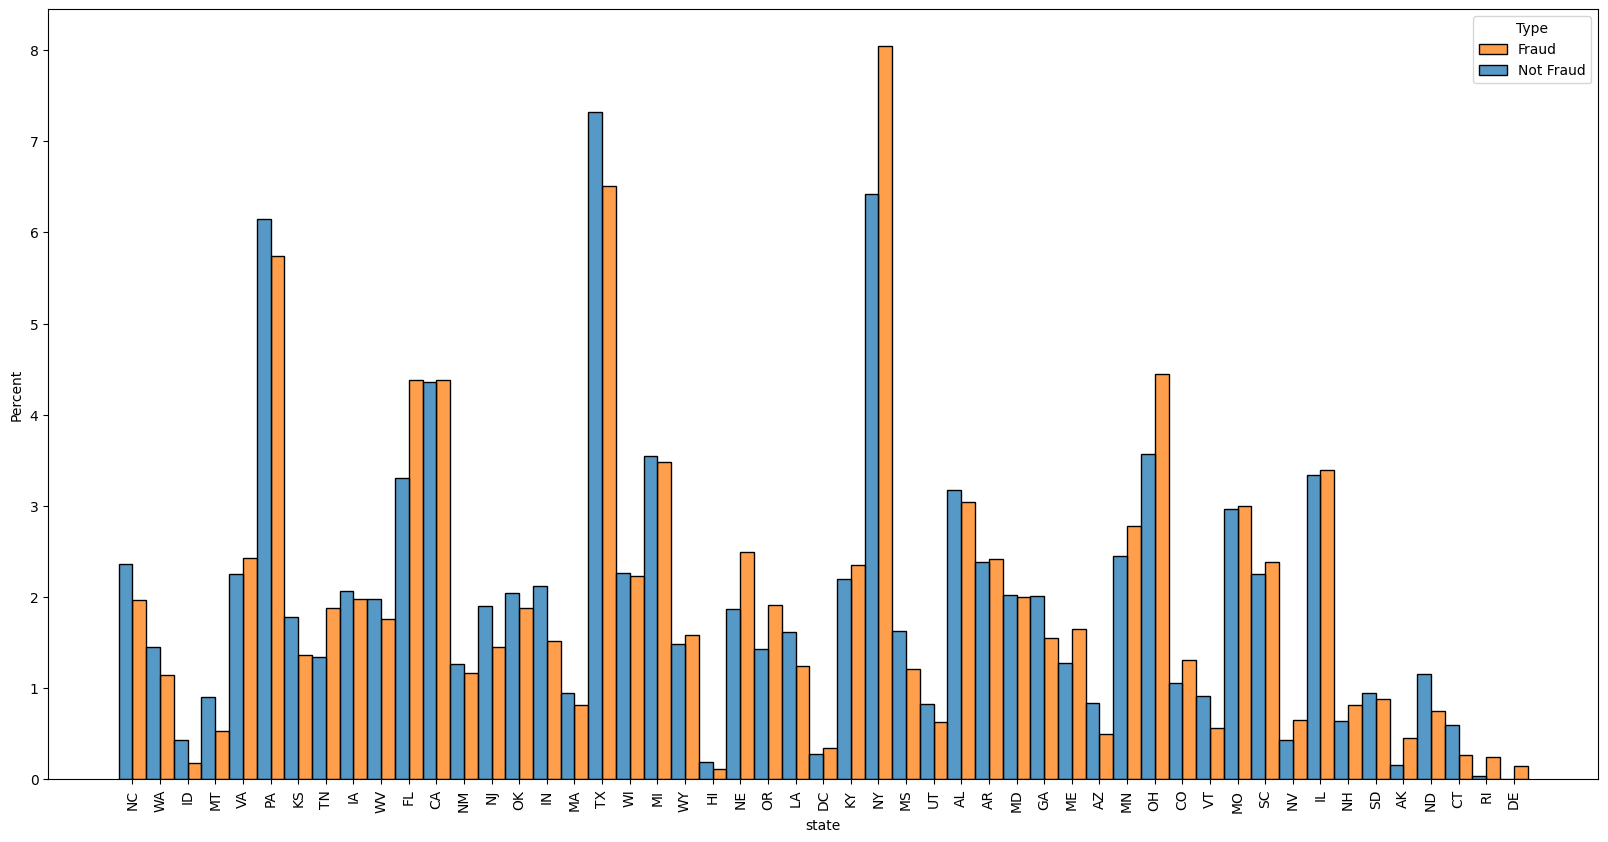

In [10]:
f, ax = plt.subplots(figsize=(20, 10))
ax=sns.histplot(x='state',data=data, hue='is_fraud',stat='percent',multiple='dodge',common_norm=False)
plt.xticks(rotation=90)
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])
plt.show();

## Model Creation

In [11]:

useful_columns=['category','amt','zip','lat','long','city_pop','merch_lat','merch_long','trans_date_trans_time','dob','is_fraud']
sample=data2[useful_columns].copy()

In [12]:
sample['age']=dt.date.today().year-pd.to_datetime(sample['dob']).dt.year
sample['hour']=pd.to_datetime(sample['trans_date_trans_time']).dt.hour
sample['day']=pd.to_datetime(sample['trans_date_trans_time']).dt.dayofweek
sample['month']=pd.to_datetime(sample['trans_date_trans_time']).dt.month
sample.pop('trans_date_trans_time')
sample.pop('dob')

0          09-03-1988
1          21-06-1978
2          19-01-1962
3          12-01-1967
4          28-03-1986
              ...    
1048570    28-05-1943
1048571    28-06-1999
1048572    02-04-1952
1048573    25-06-1990
1048574    27-12-1997
Name: dob, Length: 1048575, dtype: object

In [13]:
y=sample.pop('is_fraud')

In [14]:
X=pd.get_dummies(sample,drop_first=True)

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [16]:
new_X,new_y=SMOTE().fit_resample(X,y)

In [17]:
new_X_train,new_y_train=SMOTE().fit_resample(X_train,y_train)
new_X_test,new_y_test=SMOTE().fit_resample(X_test,y_test)

In [18]:
"""rfc=RandomForestClassifier(random_state=42)
rfc.fit(new_X_train,new_y_train)
print(classification_report(new_y_test,rfc.predict(new_X_test)))"""

'rfc=RandomForestClassifier(random_state=42)\nrfc.fit(new_X_train,new_y_train)\nprint(classification_report(new_y_test,rfc.predict(new_X_test)))'

In [19]:
"""filename = "rfc_model_4.joblib"
joblib.dump(rfc, filename)"""

'filename = "rfc_model_4.joblib"\njoblib.dump(rfc, filename)'

In [20]:
loaded_model = joblib.load("rfc_model_4.joblib")

## Metrics

In [21]:
tn, fp, fn, tp = confusion_matrix(y_test,loaded_model.predict(X_test)).ravel()

In [22]:
print(classification_report(new_y_test,loaded_model.predict(new_X_test)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    208534
           1       1.00      0.94      0.97    208534

    accuracy                           0.97    417068
   macro avg       0.97      0.97      0.97    417068
weighted avg       0.97      0.97      0.97    417068



In [24]:
def user_input(category, amt, zip, lat, long, city_pop, merch_lat,merch_long, age, hour, day, month):
    inp=[amt, zip, lat, long, city_pop, merch_lat,merch_long, age, hour, day, month]
    arr=['food_dining',
       'gas_transport', 'grocery_net',
       'grocery_pos', 'health_fitness', 'home',
       'kids_pets', 'misc_net', 'misc_pos',
       'personal_care', 'shopping_net',
       'shopping_pos', 'travel']
    for i in range(len(arr)):
        if arr[i]==category:
            inp.append(1)
        else:
            inp.append(0)
    inp=np.array(inp)
    return loaded_model.predict(inp.reshape(1,-1))
    
print((user_input('grocery_pos',281.06,28611,35.9946,-81.7266,885,36.430124,81.179483,92,1,4,2)))


[1]
